# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PotatoDiseases",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

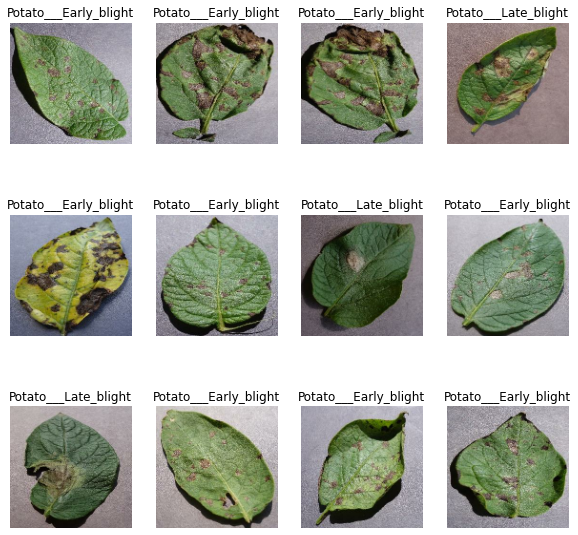

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

# MobileNetV2 Model

In [22]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [25]:
import tensorflow_hub as hub
model_handle = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

feature_extractor = hub.KerasLayer(model_handle,
                                   trainable=True)

num_class = len(class_names)

model_mobileNetV2 = tf.keras.Sequential(
    [
        normalization_layer,
        feature_extractor,
        tf.keras.layers.Dense(num_class, activation="softmax")
    ]
)

model_mobileNetV2.build([None, 128, 128, 3])
model_mobileNetV2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model_mobileNetV2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 3)                 3006      
                                                                 
Total params: 1695495 (6.47 MB)
Trainable params: 1681415 (6.41 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


In [26]:
# Early stopping when the score is over 99%
class myEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("accuracy") >= 0.99):
            print("\nReached 99% accuracy. So, cancelled!")
            self.model.stop_training = True

In [27]:
save_dir = "/"
model_save_path = save_dir + "potato_disease_detector" + ".h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_path,
                                                     save_best_only=True,
                                                     verbose=1)
model_early_stop = myEarlyStopping()

history = model_mobileNetV2.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    validation_data=val_ds,
                    verbose=1,
                    epochs=15,
                        callbacks=[model_checkpoint, model_early_stop])

Epoch 1/15
54/54 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.9288
Epoch 1: val_loss improved from inf to 0.18207, saving model to /potato_disease_detector.h5


C:\Users\Pradeeshwar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - 53s 719ms/step - loss: 0.5440 - accuracy: 0.9288 - val_loss: 0.1821 - val_accuracy: 0.9635
Epoch 2/15
54/54 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9855
Epoch 2: val_loss did not improve from 0.18207
54/54 [==============================] - 37s 676ms/step - loss: 0.1592 - accuracy: 0.9855 - val_loss: 0.7143 - val_accuracy: 0.9271
Epoch 3/15
54/54 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9873
Epoch 3: val_loss did not improve from 0.18207
54/54 [==============================] - 35s 657ms/step - loss: 0.1232 - accuracy: 0.9873 - val_loss: 0.3513 - val_accuracy: 0.9375
Epoch 4/15
54/54 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9902
Epoch 4: val_loss improved from 0.18207 to 0.08834, saving model to /potato_disease_detector.h5

Reached 99% accuracy. So, cancelled!
54/54 [==============================] - 42s 782ms/step - loss: 0.1407 - accuracy: 0.9902 - va

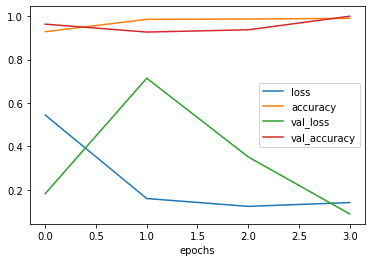

In [28]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.xlabel("epochs")
plt.show()

In [32]:
scores = model_mobileNetV2.evaluate(test_ds)

8/8 [==============================] - 2s 94ms/step - loss: 0.1198 - accuracy: 0.9922


In [34]:
scores

[0.11980956792831421, 0.9921875]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
type(history.history['loss'])

list

In [40]:
len(history.history['loss'])

4

In [41]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.5439684987068176,
 0.15922391414642334,
 0.12319108098745346,
 0.14068299531936646]

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

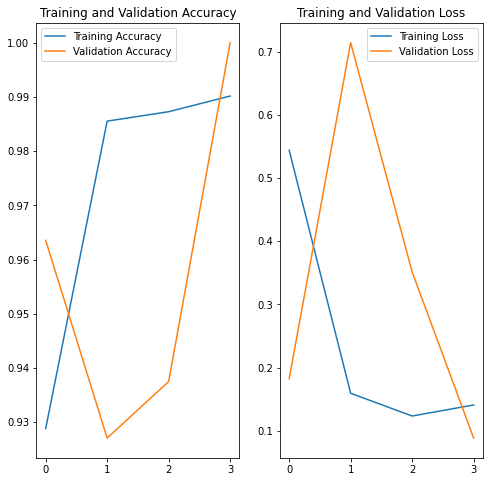

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(4), acc, label='Training Accuracy')
plt.plot(range(4), val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(4), loss, label='Training Loss')
plt.plot(range(4), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()